In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def cvshow(name,img):
   
    plt.figure(figsize=(20,10))
    plt.title(name)
    plt.imshow(img)

def sift_kp(image):
    # Vrati keypointy, descriptory a obrazok s nimi
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(image, None)
    kp_image = cv2.drawKeypoints(gray_image, kp, None)
    return kp_image, kp, des

def get_good_match(des1, des2):
    # Hľadanie zhody medzi keypointmi
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)  # des1 is the template image, des2 is the matching image
    matches = sorted(matches, key=lambda x: x[0].distance / x[1].distance)
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    return good

def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):

    # Obrazok s vykreslenimi zhodami medzi lavym a pravym orazkom
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB

    # Vykreslovanie zhodnych parov
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # Ak sa najde zhodny par, vykresli ho
        if s == 1:
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (255, 50, 100), 1)

    return vis

# Spájanie obrázkov
def siftimg_rightlignment(img_right, img_left):
    _, kp1, des1 = sift_kp(img_right)
    _, kp2, des2 = sift_kp(img_left)
    goodMatch = get_good_match(des1, des2)

    if len(goodMatch) > 4:
        ptsA = np.float32([kp1[m.queryIdx].pt for m in goodMatch]).reshape(-1, 1, 2)
        ptsB = np.float32([kp2[m.trainIdx].pt for m in goodMatch]).reshape(-1, 1, 2)
        ransacReprojThreshold = 4
        H, status = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, ransacReprojThreshold)


        result = cv2.warpPerspective(img_right, H, (img_right.shape[1] + img_left.shape[1], img_right.shape[0]))
        cvshow('result_medium', result)

        result[0:img_left.shape[0], 0:img_left.shape[1]] = img_left
        return result

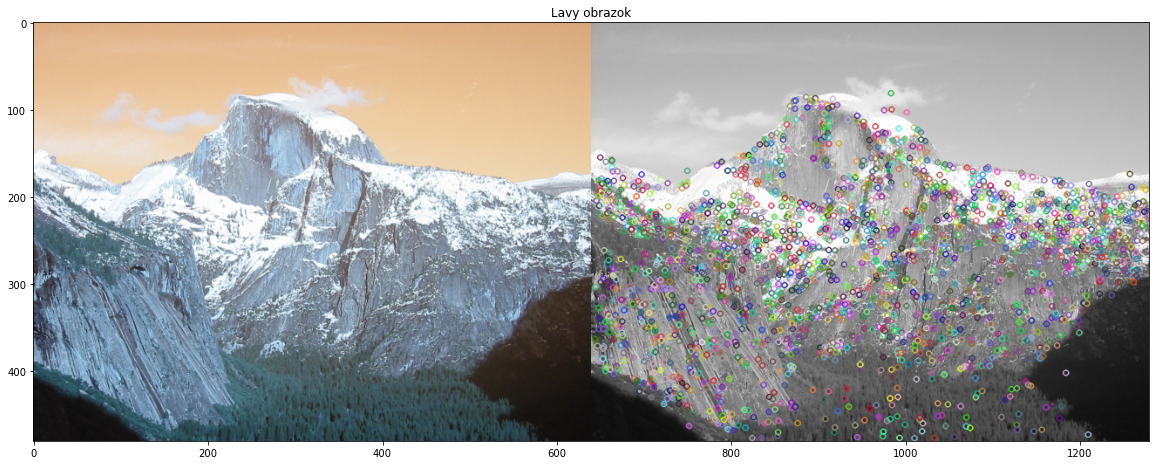

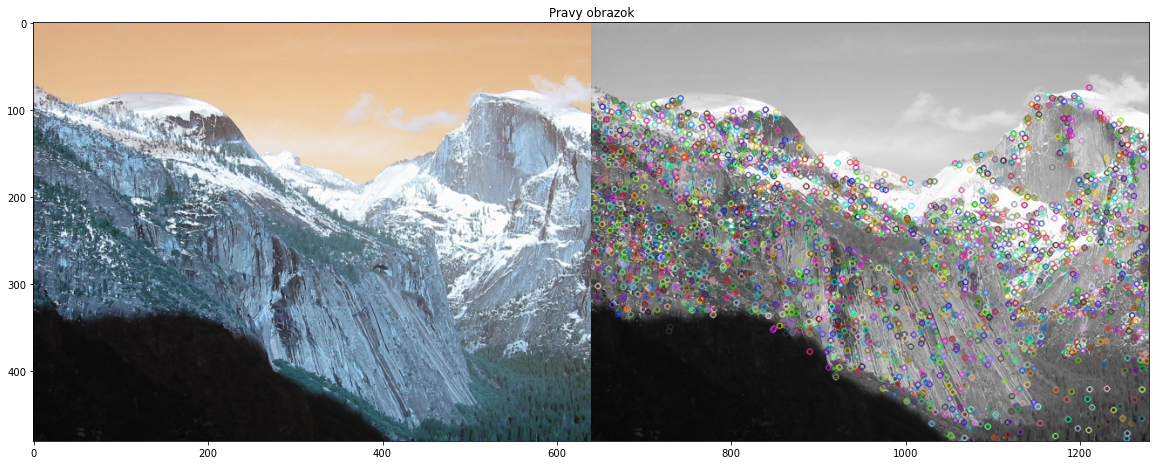

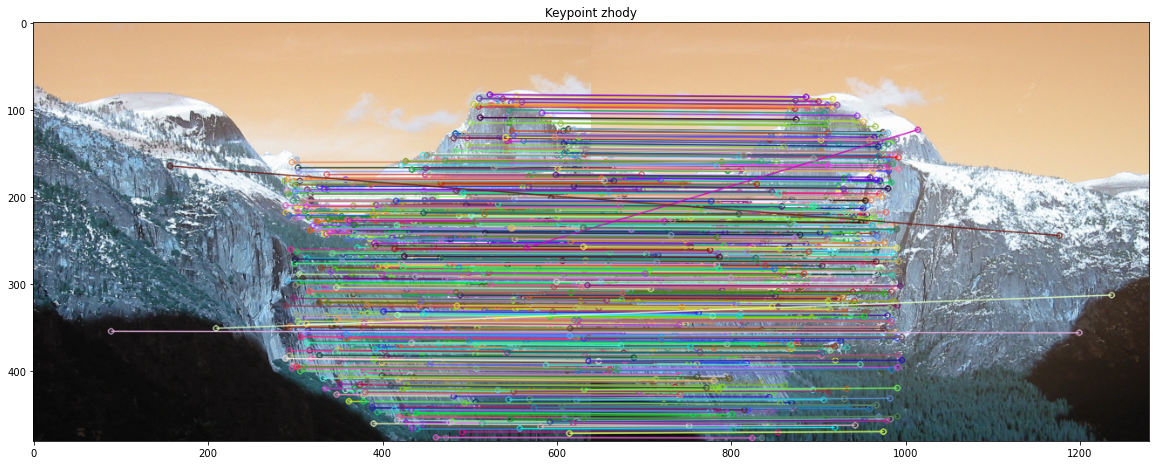

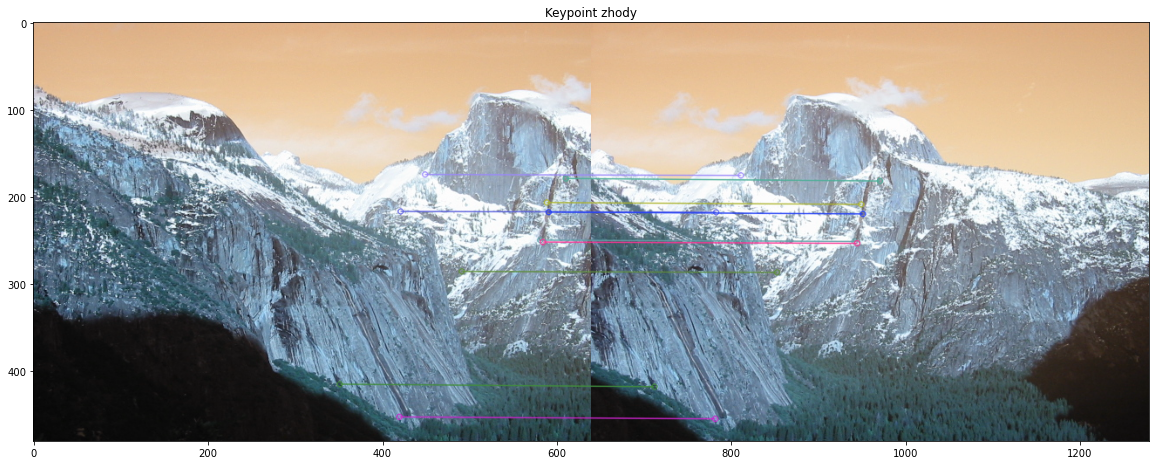

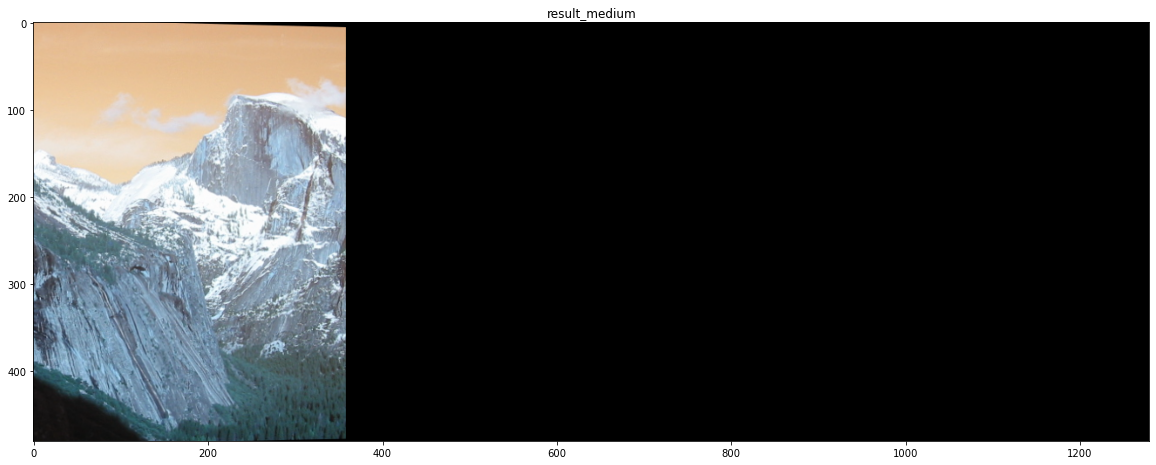

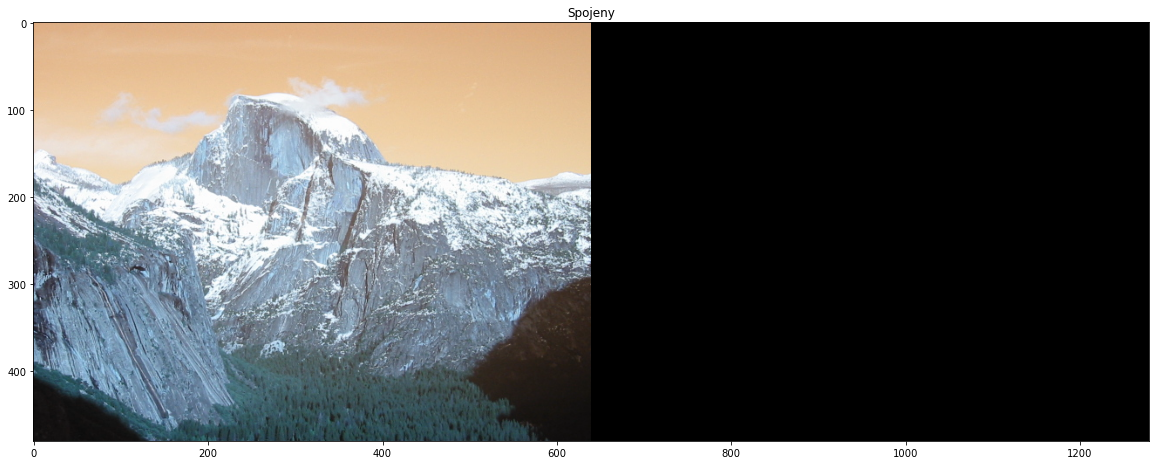

In [3]:
# nacitanie obrazkov
img_right = cv2.imread("C:/Users/olive/Documents/PPV/prvy.png")
img_left = cv2.imread("C:/Users/olive/Documents/PPV/druhy.png")


kpimg_right, kp1, des1 = sift_kp(img_right)
kpimg_left, kp2, des2 = sift_kp(img_left)

cvshow('Lavy obrazok',np.hstack((img_left,kpimg_left)))
cvshow('Pravy obrazok',np.hstack((img_right,kpimg_right)))
goodMatch = get_good_match(des1, des2)

all_goodmatch_img= cv2.drawMatches(img_right, kp1, img_left, kp2, goodMatch, None, flags=2)

goodmatch_img = cv2.drawMatches(img_right, kp1, img_left, kp2, goodMatch[:10], None, flags=2)

cvshow('Keypoint zhody', all_goodmatch_img)
cvshow('Keypoint zhody', goodmatch_img)

result=siftimg_rightlignment(img_right,img_left)
cvshow('Spojeny',result)